# Notebook for analysing *aversive* conditioning in the two-landmark forest with teleportation training
## Training trial (30 min) + post trial (10 min)

In [96]:
import numpy as np
import pandas as pd
    
from os import listdir, mkdir, walk, getcwd
from os.path import isfile, sep, exists
from sys import path, exit
from glob import glob
from operator import itemgetter

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec
import seaborn as sns

from Tkinter import Tk
from tkFileDialog import askdirectory, askopenfilename

# Set path to analysis code directory
codeDir = sep.join(getcwd().split(sep)[:-2])
path.insert(1, codeDir)

from flyVR.flyVRoptogenetics.flyVRoptogenetics_oneTrialBasicAnalysis import singleTwoObjVRTeleportTrialAnalysis

from plottingUtilities.basicPlotting import myAxisTheme,_myAccentList
from plottingUtilities.objectInteractionPlots import plotWalkingVelocityDistr
from plottingUtilities.plotsWithDataframe import plotVeloHeadingDistribution_flyVR_df,\
            plotVeloHeadingDistribution2_flyVR_df,oneDimResidencyWithVar_2LM_df
from plottingUtilities.objectPreferencePlots import countvisits, diffCorrPlot, prettyBoxPlot, simpleBoxPlot_tele, \
        landmarksInSquareTile


# Choose files to analyse ..............................................................................................

baseDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/teleportOpto/'

root = Tk()
# prevents root window from appearing
root.withdraw()
# choose experiment folder
dataDir = askdirectory(initialdir=baseDir,
                       title='Select experiment directory (containing directories for multiple flies)') + sep
root.update()
root.destroy()
expDirs = sorted(walk(dataDir).next()[1])

analysisDir = sep.join(dataDir.split(sep)[:-2]) + sep + 'analysis' + sep

try:
    expDirs.remove('virtualWorld')
except:
    print('You selected an invalid data directory.\n' +
          'Expected folder structure of the selected path is some/path/to/experimentName/flyGender/rawData/')
    exit(1)

print('\n Analysing the following folders:\n')
print(expDirs)

rerunbasicanalysis = raw_input('Would you like to (re-)run the basic analysis on each file \n'
                               'instead of loading previously saved data? (y, n)\n')


 Analysing the following folders:

['m01', 'm02', 'm03', 'm04', 'm05', 'm06']
Would you like to (re-)run the basic analysis on each file 
instead of loading previously saved data? (y, n)
n


In [97]:
# Uncomment, if you want to select a specific subset of flies (e.g. good learners..)
#my_indices = [0,1,2,3]
#expDirs = itemgetter(*my_indices)(expDirs)

selectionTag = ''  # chose small string, to specify dataset (e.g. top5 flies)

In [98]:
expDirs=expDirs[:]
print(expDirs)

['m01', 'm02', 'm03', 'm04', 'm05', 'm06']


In [99]:
%matplotlib inline

### Compose mutli-fly data into dataframe

In [100]:
# generate fly color map
numFlies = len(expDirs)
cNorm  = colors.Normalize(vmin=0, vmax=numFlies)

mycmap = colors.LinearSegmentedColormap.from_list('myAccent',_myAccentList, N=256, gamma=1.0)
flyCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=mycmap)

In [101]:
expDir = dataDir + expDirs[0] + sep
FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]

In [102]:
genotype = dataDir.split(sep)[-5]
condition = dataDir.split(sep)[-4]
print(genotype)
print(condition)

HC-Gal4_x_10xChrimsonR-WTB
antiCyliProCone


In [103]:
keylist = ['headingAngle','rotVelo','time','transVelo',
           'xPos','yPos','rEvents']

keylistLong = ['flyID','trial','trialtype','reinforcement','condition','moving'] + keylist
FOAllFlies_df = pd.DataFrame(data=np.zeros((0,len(keylistLong))), columns=keylistLong)

vTransTH = 2 #mm/s

# Go through directories of experiments with different flies ...............................................
for currExpDir in expDirs:

    expDir = dataDir + currExpDir + sep
    print('\n Analysing the following folder:\n')
    print(expDir)

    FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]
    FODataFiles = sorted(FODataFiles)

    print('\n Analysing the following log files:\n')
    print(FODataFiles)

    # Run single trial analysis on each file in folder .....................................................
    for fileToAnalyse in FODataFiles:
        
        flyID = currExpDir
        stimT = fileToAnalyse.split('_')[8]
        
        trial = FODataFiles.index(fileToAnalyse) + 1
        
        if rerunbasicanalysis == 'y':
            returnVal = singleTwoObjVRTeleportTrialAnalysis(expDir + fileToAnalyse)
            print('Ran analysis, now loading saved *.npy file.')
            FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]
        else:
            print('Loading saved *.npy file.')
            FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]

        # Split into visible object trials and invisible object trials
        if 'train' in fileToAnalyse:
            trialtype = 'train'
            rZones = 'on'
        else:
            trialtype = 'post'
            rZones = 'off'
        
        vTrans = np.copy(FODatLoad['transVelo'])
        moving = vTrans >= vTransTH

        FODatLoad_df = pd.DataFrame.from_dict(FODatLoad,orient='columns')
        FODatLoad_df.insert(0, 'flyID', flyID)
        FODatLoad_df.insert(1, 'trial', trial)
        FODatLoad_df.insert(2, 'trialtype', trialtype)
        FODatLoad_df.insert(3, 'reinforcement', rZones)
        FODatLoad_df.insert(4, 'condition', condition)
        FODatLoad_df.insert(5, 'moving', moving)
        
        FOAllFlies_df = FOAllFlies_df.append(FODatLoad_df)


 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/teleOpto/HC-Gal4_x_10xChrimsonR-WTB/antiCyliProCone/male/rawData/m01/

 Analysing the following log files:

['twoObjectTeleport-25mm7s_1cm4cmConez1R_08cm3cmCyliz2_antiCyliProCone_6-7d_HCx10xChrR-WTB_10bl_m01_post_180706160618.txt', 'twoObjectTeleport-25mm7s_1cm4cmConez1R_08cm3cmCyliz2_antiCyliProCone_6-7d_HCx10xChrR-WTB_10bl_m01_train_180706153602.txt']
Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/teleOpto/HC-Gal4_x_10xChrimsonR-WTB/antiCyliProCone/male/rawData/m02/

 Analysing the following log files:

['twoObjectTeleport-25mm7s_1cm4cmConez1R_08cm3cmCyliz2_antiCyliProCone_8-9d_HCx10xChrR-WTB_10bl_m02_post_180708193940.txt', 'twoObjectTeleport-25mm7s_1cm4cmConez1R_08cm3cmCyliz2_antiCyliProCone_8-9d_HCx10xChrR-WTB_10bl_m02_train_180708190915.txt']
Loading saved *.npy file.
Loading saved *.npy file

In [104]:
FOAllFlies_df = FOAllFlies_df[keylistLong]

FOAllFlies_df['flyID'] = FOAllFlies_df['flyID'].astype('category')
FOAllFlies_df['trial'] = FOAllFlies_df['trial'].astype('category')
FOAllFlies_df['trialtype'] = FOAllFlies_df['trialtype'].astype('category')
FOAllFlies_df['reinforcement'] = FOAllFlies_df['reinforcement'].astype('category')

FOAllFlies_df

,flyID,trial,trialtype,reinforcement,condition,moving,headingAngle,rotVelo,time,transVelo,xPos,yPos,rEvents
0,m01,1.0,post,off,antiCyliProCone,0.0,6.395358e-07,-0.382163,0.000000,0.691692,0.000000,0.000000,10.0
1,m01,1.0,post,off,antiCyliProCone,0.0,-1.910944e-02,0.000000,0.050005,0.000000,-0.024175,0.024736,10.0
2,m01,1.0,post,off,antiCyliProCone,0.0,-1.910944e-02,-0.076431,0.100010,0.000000,-0.024175,0.024736,10.0
3,m01,1.0,post,off,antiCyliProCone,1.0,-2.293136e-02,0.000280,0.150015,2.493190,-0.024175,0.024736,10.0
4,m01,1.0,post,off,antiCyliProCone,1.0,-2.291734e-02,0.765071,0.200020,3.524531,0.097523,-0.002332,10.0
5,m01,1.0,post,off,antiCyliProCone,1.0,1.534010e-02,0.687241,0.250025,3.518014,0.244255,-0.099963,10.0
6,m01,1.0,post,off,antiCyliProCone,1.0,4.970566e-02,-0.155244,0.300031,2.500358,0.394505,-0.191463,10.0
7,m01,1.0,post,off,antiCyliProCone,1.0,4.194269e-02,-1.989702,0.350036,4.009767,0.365566,-0.069828,10.0
8,m01,1.0,post,off,antiCyliProCone,1.0,-5.755254e-02,-4.050085,0.400041,6.169300,0.323964,0.126318,10.0
9,m01,1.0,post,off,antiCyliProCone,1.0,-2.600775e-01,-4.356946,0.450046,6.396488,0.279388,0.431577,10.0


In [105]:
flyIDallarray = np.asarray(FOAllFlies_df['flyID'].values).squeeze()
flyIDs = sorted(list(set(flyIDallarray.tolist())))

In [106]:
keyind_mov = keylistLong.index('moving')
keyind_fly = keylistLong.index('flyID')
keyind_vT = keylistLong.index('transVelo')
keyind_ang = keylistLong.index('headingAngle')
keyind_t = keylistLong.index('time')
keyind_vR = keylistLong.index('rotVelo')
keyind_EV = keylistLong.index('rEvents')

### Define structure of trials in terms of closed-loop optogenetic stimulation and presence of landmark cues

In [107]:
# Two object reinforcement test
rZoneState = ['on','off']
trialName = ['train','post']
gridSize = 60.0

fps = 20.0 # after downsampling

coneColor = 'mediumseagreen'
cyliColor = 'mediumorchid'

LMCols = [coneColor,cyliColor]
LMnames = ['Cone', 'Cylinder']
numLM = len(LMnames)

visitRad = 20
# Use 15 mm as standard visit radius with two-landmark forest world, where
# LM are at least 60 mm separated.

coneCoords = [[gridSize/2, gridSize/2],
              [-gridSize/2, -gridSize/2]]
cyliCoords = [[gridSize/2, -gridSize/2],
              [-gridSize/2, gridSize/2]]

LMcoords = [coneCoords,cyliCoords]

### Count visits

In [121]:
visitFreq = np.nan*np.ones((numLM, len(flyIDs), len(trialName)))
visitCount = np.nan*np.ones((numLM, len(flyIDs), len(trialName)))
visitLength = np.zeros((numLM, len(flyIDs), len(trialName)))

for fly in range(len(flyIDs)):
    for trial in range(len(trialName)):
        trialtype =trialName[trial]

        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        xtrial = FOAllFlies_df.query(querystring)['xPos'].values.squeeze()
        ytrial = FOAllFlies_df.query(querystring)['yPos'].values.squeeze()
        time = FOAllFlies_df.query(querystring)['time'].values.squeeze()

        # compute distance to closest landmark for each type
        dist2closest = np.nan*np.ones( (numLM, len(xtrial)) )
        
        for obj in range(numLM):
            dist2closest[obj,:] = np.minimum( np.hypot((xtrial-LMcoords[obj][0][0]),(ytrial-LMcoords[obj][0][1])),
                                           np.hypot((xtrial-LMcoords[obj][1][0]),(ytrial-LMcoords[obj][1][1])) )
            
            entries,exits,visitT,entryTime,exitTime = countvisits(dist2closest[obj,:],time,visitRad)
        
            visitFreq[obj,fly,trial] = np.sum(entries)/(time[-1]/60.0)
            visitCount[obj,fly,trial] = np.sum(entries)
            visitLength[obj,fly,trial] = np.sum(visitT)

In [122]:
np.sum(visitCount, axis=0)

array([[ 31.,   6.],
       [ 67.,  29.],
       [ 72.,  16.],
       [ 21.,  10.],
       [ 25.,   1.],
       [ 89.,  26.]])

### Selection of flies for analysis based on landmark visits

In [110]:
# minimum amount of visits to ANY landmark in any trial to be considered in ananlysis
minVisit = 3

notEnoughVisits = np.where(np.sum((visitCount[0][:,:] + visitCount[1][:,:])>= minVisit, axis=1)<len(trialName))[0]
keepflies = list(np.where(np.sum((visitCount[0][:,:] + visitCount[1][:,:])>= minVisit, axis=1)>=len(trialName))[0])

# median # visits during training in group of flies that performed minimum amount of visits:
keepMedian = np.median(visitCount[0][keepflies,1])

# split flies to keep along the median
aboveMedian = list(set(np.where(visitCount[0][:,1]>keepMedian)[0]).intersection(set(keepflies)))
belowMedian = list(set(np.where(visitCount[0][:,1]<=keepMedian)[0]).intersection(set(keepflies)))

print('Out of {} measured flies, {} made less than {} landmark visits in at least one of the three trials ({}%).\n').format(numFlies,
     len(notEnoughVisits), minVisit, 100*len(notEnoughVisits)/numFlies)
print('Flies that made enough visits:')
print(keepflies)
print('\n')
print('The remaining {} flies can be split along the median of {} visits:').format(len(keepflies), keepMedian)
print('Above median:')
print(aboveMedian)
print('Below or equal to median:')
print(belowMedian)

Out of 6 measured flies, 1 made less than 3 landmark visits in at least one of the three trials (16%).

Flies that made enough visits:
[0, 1, 2, 3, 5]


The remaining 5 flies can be split along the median of 9.0 visits:
Above median:
[1, 5]
Below or equal to median:
[0, 2, 3]


### Trajectory plots of all trials

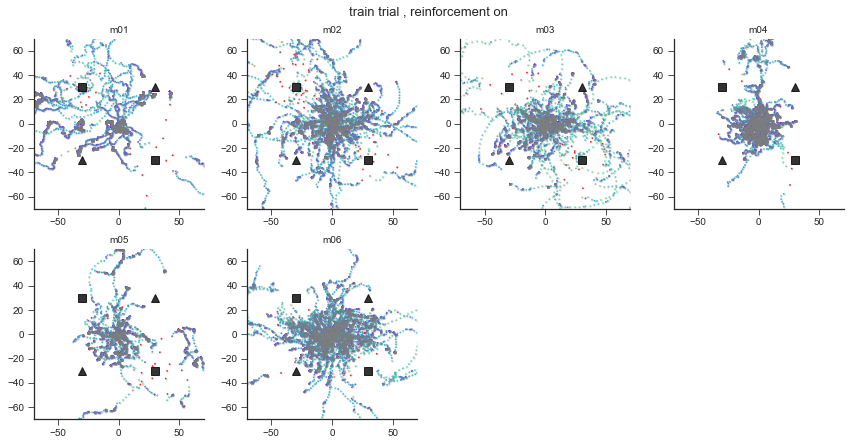

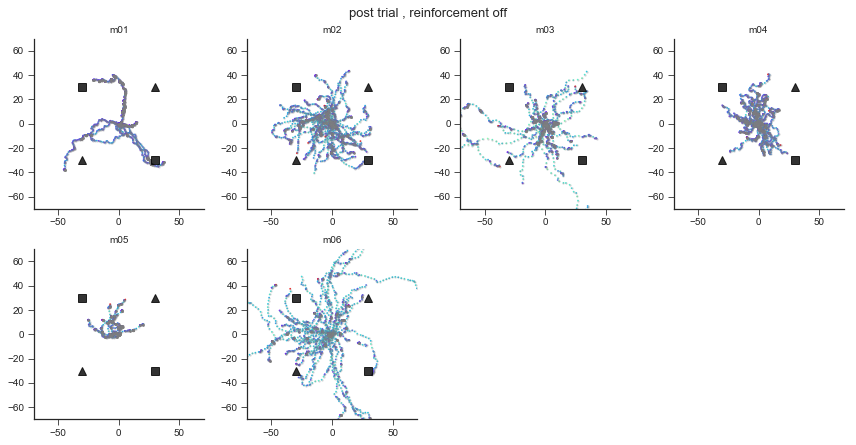

In [111]:
nrows = np.ceil(numFlies/4.0)
for ttind,trialtype in enumerate(trialName):
    multiflyTracePlot = plt.figure(figsize=(12,3*nrows))
    figtitle = multiflyTracePlot.suptitle(trialtype + ' trial , reinforcement ' + rZoneState[ttind] ,fontsize=13,y=1.02)
    for fly in range(numFlies):
        multiflyTracePlot_sbplt = multiflyTracePlot.add_subplot(nrows,4,fly+1)
       
        querystring = '(trialtype=="' + trialtype + '") & (flyID =="' + flyIDs[fly] +  '")'

        perFlyX = FOAllFlies_df.query(querystring)['xPos'].values.squeeze()
        perFlyY = FOAllFlies_df.query(querystring)['yPos'].values.squeeze()
        perFlyvT = FOAllFlies_df.query(querystring)['transVelo'].values.squeeze()
        
        selectPts = range(0,len(perFlyX),5)
        multiflyTracePlot_sbplt.plot(perFlyX[selectPts],perFlyY[selectPts],'.',markersize=3,color='grey',alpha=0.2)
        multiflyTracePlot_sbplt.scatter(perFlyX[selectPts],perFlyY[selectPts],s=3, c=perFlyvT[selectPts], cmap='rainbow',
                                        vmin=-1, vmax=35, edgecolor='none',alpha=0.9)
        
        landmarksInSquareTile(multiflyTracePlot_sbplt,LMcoords,['black','black'])

        myAxisTheme(multiflyTracePlot_sbplt)
        multiflyTracePlot_sbplt.set_title(flyIDs[fly],fontsize=10)
        multiflyTracePlot_sbplt.set_aspect('equal')
        multiflyTracePlot_sbplt.set_xlim(-(10 + gridSize), gridSize + 10)
        multiflyTracePlot_sbplt.set_ylim(-(10 + gridSize), gridSize + 10)
        
    multiflyTracePlot.tight_layout()
    
    multiflyTracePlot.savefig(analysisDir +'tracePlot/'+ genotype +'_'+flyIDs[0][0] +'_'+ trialtype +'_trial'+ rZoneState[ttind]
                              +'_traceVeloColored_trial'+ str(ttind+1) +'_n'+ str(len(flyIDs))+selectionTag+'.pdf', format='pdf', 
                              bbox_extra_artists=(figtitle,), bbox_inches='tight')

## Velocity distributions

In [112]:
histRangeVT = (vTransTH, 30)
histRangeVR = (-5,5)
numBins = 31

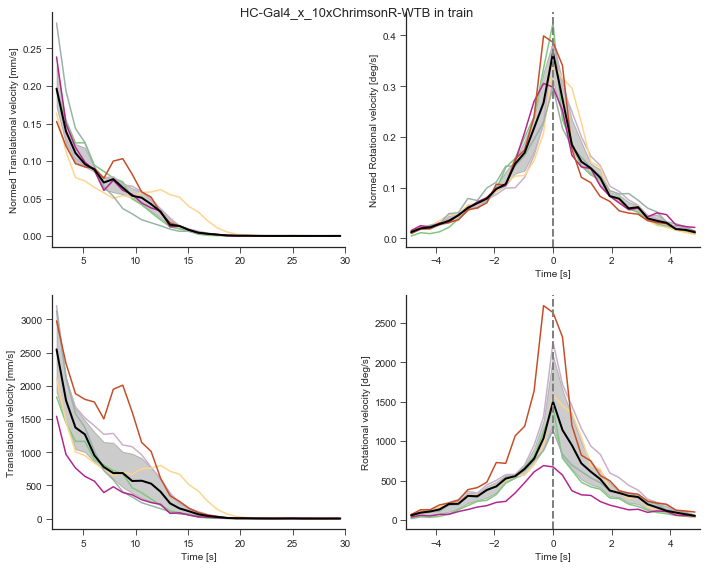

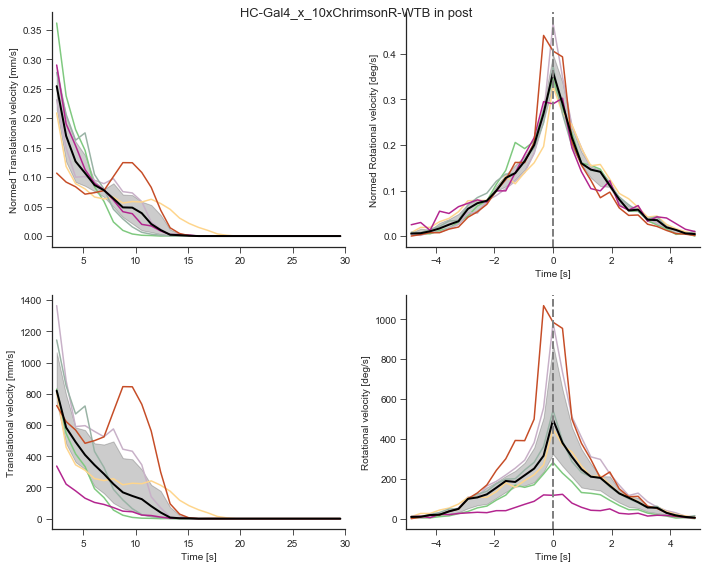

In [113]:
for tind, tname in enumerate(trialName):
    scene_df = FOAllFlies_df.query('trialtype == "' + tname + '"')
    titleString = genotype+' in '+ tname
    
    walkingFig = plotWalkingVelocityDistr(scene_df, flyIDs, keyind_mov, keyind_vT, keyind_vR, flyCMap,
                                 histRangeVT, histRangeVR,numBins, numFlies)
    walkingFig.suptitle(titleString, fontsize=13)
    walkingFig.tight_layout()

    walkingFig.savefig(analysisDir + sep + 'velocityTraces' + sep + genotype + '_walingVelocities_'+tname+\
                       '_medianIQR_n'+str(numFlies)+selectionTag+'.pdf', format = 'pdf')

## Residency

### 2D (cartesian) residency

Plot directory already exists


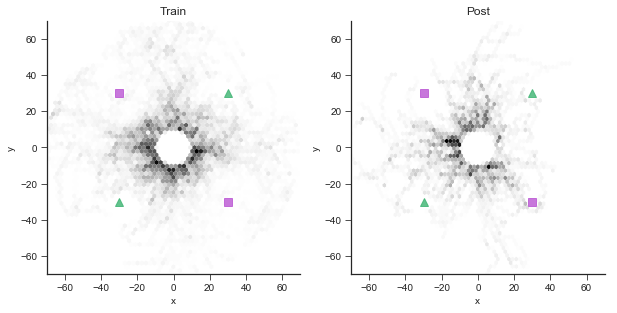

In [114]:
# plot parameter
numBins = 60

maxDist = gridSize+10
minDist = 10

hexplotfig = plt.figure(figsize=(10,5))
for trial, condition in enumerate(trialName):
    querystring = '(trialtype == "' + condition + '") & (moving > 0)'
    xPos = np.asarray(FOAllFlies_df.query(querystring)['xPos'].values)
    yPos = np.asarray(FOAllFlies_df.query(querystring)['yPos'].values)
    
    dist = np.hypot(xPos,yPos)
    slct = np.logical_and(dist<maxDist, dist>=minDist)

    ax = hexplotfig.add_subplot(1,len(trialName),trial+1)
    ax.hexbin(xPos[slct], yPos[slct], gridsize=numBins, cmap='Greys', vmin=0, linewidths=0)
    plt.xlabel('x'); plt.ylabel('y')
    
    landmarksInSquareTile(ax,LMcoords,LMCols)
            
    ax.set_title(trialName[trial].capitalize())
    ax.set_xlim(-maxDist,maxDist)
    ax.set_ylim(-maxDist,maxDist)
    
try:
    mkdir(analysisDir + 'residencyPlots/')
except:
    print('Plot directory already exists')
hexplotfig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0]
                   +'_residencyMA_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

### 1D radial residency close around objects

In [115]:
resdf_keylist_short = ['flyID','trial','trialtype','reinforcement','moving','time']
resdf_keylist = resdf_keylist_short + ['dist2cone','dist2cyli']
residency_df = pd.DataFrame(data=np.zeros((0,len(resdf_keylist))), columns=resdf_keylist)

for trial, trialtype in enumerate(trialName):
    for fly in range(len(flyIDs)):

        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        xPos = FOAllFlies_df.query(querystring)['xPos'].values
        yPos = FOAllFlies_df.query(querystring)['yPos'].values
        timeTrial = FOAllFlies_df.query(querystring)['time'].values
        
        # compute distance to each landmark
        dist2cone1 = np.hypot((xPos-coneCoords[0][0]),(yPos-coneCoords[0][1]))
        dist2cone2 = np.hypot((xPos-coneCoords[1][0]),(yPos-coneCoords[1][1]))
        dist2cyli1 = np.hypot((xPos-cyliCoords[0][0]),(yPos-cyliCoords[0][1]))
        dist2cyli2 = np.hypot((xPos-cyliCoords[1][0]),(yPos-cyliCoords[1][1]))

        # compute distance to closest landmark
        dist2closestCone = np.minimum(dist2cone1,dist2cone2)
        dist2closestCyli = np.minimum(dist2cyli1,dist2cyli2)
        
        tmpdf = FOAllFlies_df.query(querystring)[resdf_keylist_short]
        tmpdf.insert(1,'dist2cone', dist2closestCone)
        tmpdf.insert(2,'dist2cyli', dist2closestCyli)
        
        residency_df = residency_df.append(tmpdf)

residency_df = residency_df[resdf_keylist]

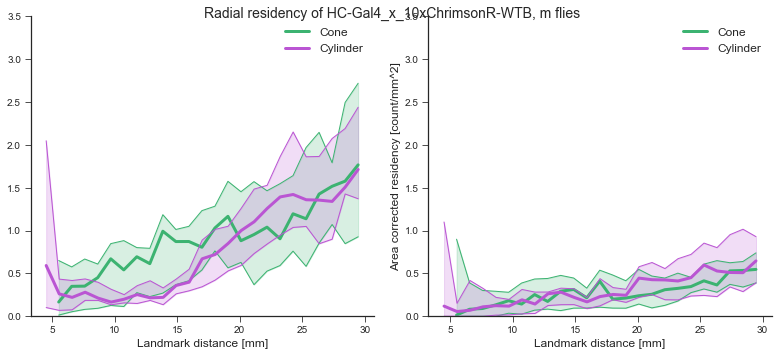

In [116]:
movementFilter = 'moving > 0'
histMax = (30,30)
histMin = (5,4) # adjust to LM base width
numBins = (25, 26)
varStyle = 'iqr' #'std', 'iqr'

keyind_dCone = resdf_keylist.index('dist2cone')
keyind_dCyli = resdf_keylist.index('dist2cyli')

# linear residency
radResFig = plt.figure(figsize=(11,5))
radResFig = oneDimResidencyWithVar_2LM_df(radResFig, residency_df, flyIDs, trialName,keyind_dCone, keyind_dCyli,
                                          movementFilter, numBins, histMin, histMax, 1, varStyle, LMCols, LMnames)
radResFig.suptitle('Radial residency of '+genotype+', '+flyIDs[0][0]+' flies',fontsize=14)
radResFig.tight_layout()

radResFig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0]
                   +'_radialResidencyVar_'+varStyle+'_lin_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

## Visit-based analysis

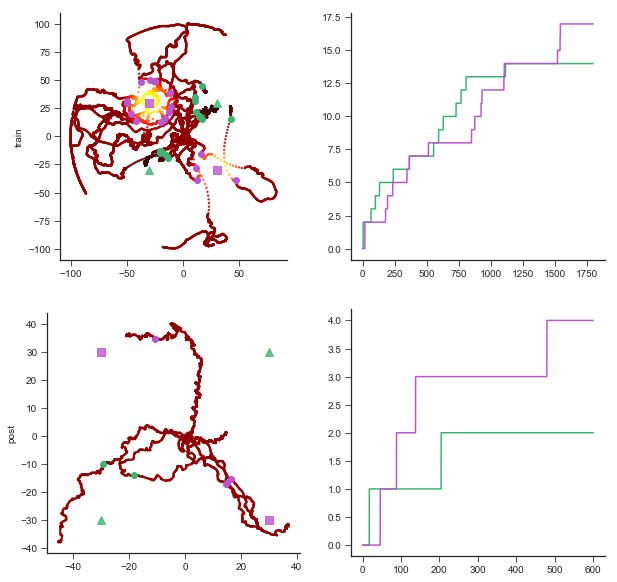

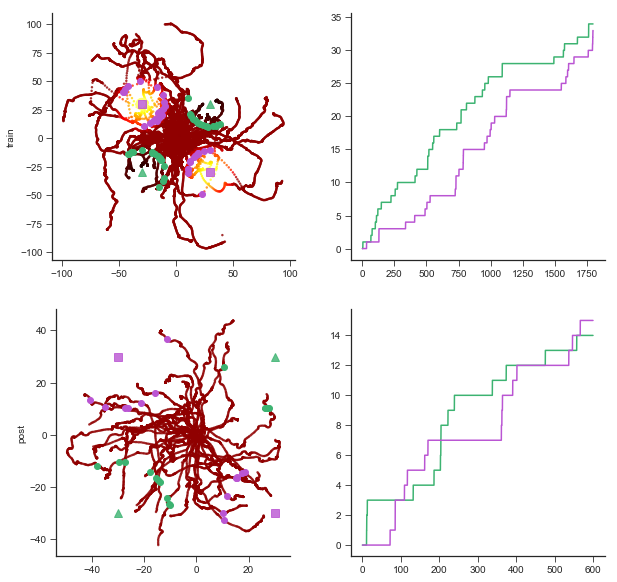

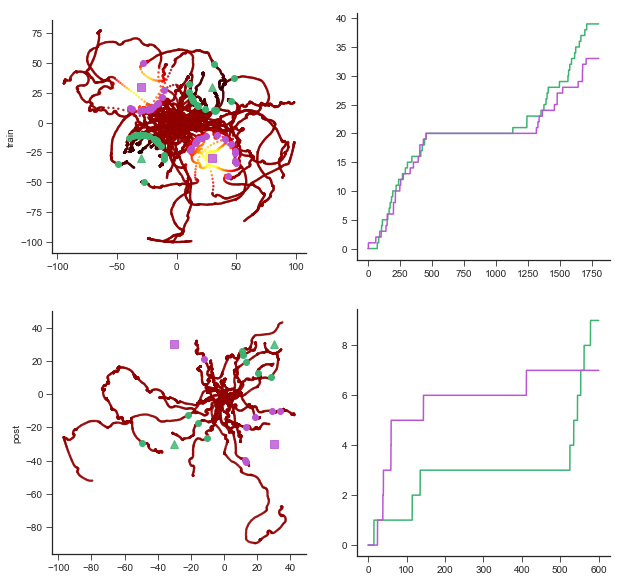

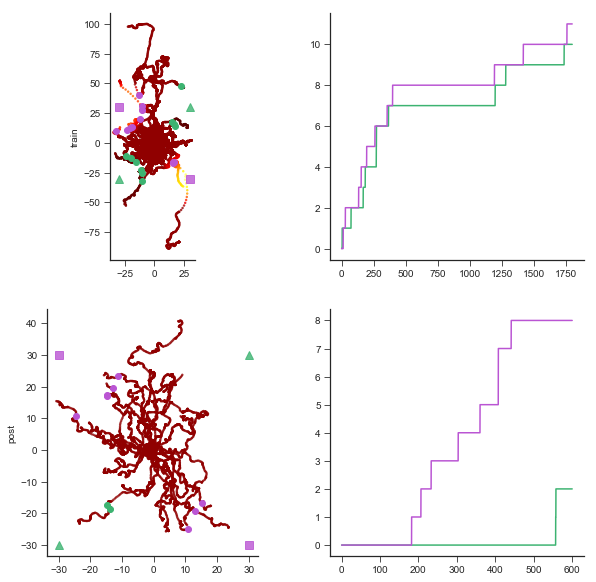

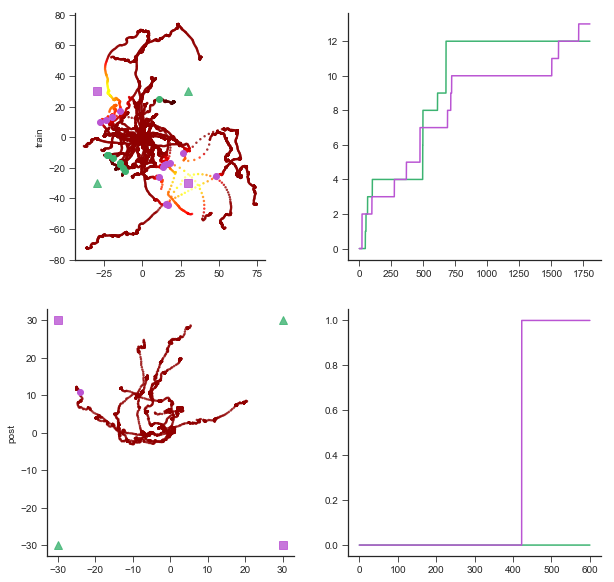

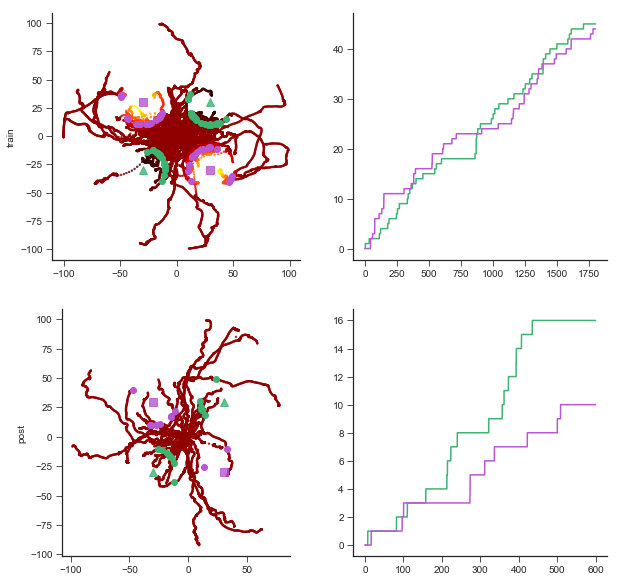

In [117]:
if exists(analysisDir + 'reinforcementEffect/'):
    if not exists(analysisDir + 'reinforcementEffect/individualFlies/'):
        mkdir(analysisDir + 'reinforcementEffect/individualFlies/')
else:
    mkdir(analysisDir + 'reinforcementEffect/')
    mkdir(analysisDir + 'reinforcementEffect/individualFlies/')

for fly in range(len(flyIDs)):
    visitFig = plt.figure(figsize=(10,10))
    gs = gridspec.GridSpec(len(trialName),2,width_ratios=[1,1])

    for trial in range(len(trialName)):
        trialtype =trialName[trial]

        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        xtrial = FOAllFlies_df.query(querystring)['xPos'].values.squeeze()
        ytrial = FOAllFlies_df.query(querystring)['yPos'].values.squeeze()
        timeTrial = FOAllFlies_df.query(querystring)['time'].values.squeeze()
        evTrial = FOAllFlies_df.query(querystring)['rEvents'].values.squeeze()
        
        # setup figure
        visitPlt = visitFig.add_subplot(gs[trial,0])
        cumsumVisitPlt = visitFig.add_subplot(gs[trial,1])
        
        #visitPlt.plot(xtrial,ytrial,'.',color='darkgrey',markersize=4,alpha=0.1)
        visitPlt.scatter(xtrial[evTrial>0],ytrial[evTrial>0],s=6,c=evTrial[evTrial>0], cmap='hot',
                         edgecolors='none',alpha=0.8,vmin=0,vmax=50)
        
        # compute visits to each landmark
        dist2closest = np.nan*np.ones( (numLM, len(xtrial)) )
        
        for obj in range(numLM):
            dist2closest[obj,:] = np.minimum( np.hypot((xtrial-LMcoords[obj][0][0]),(ytrial-LMcoords[obj][0][1])),
                                           np.hypot((xtrial-LMcoords[obj][1][0]),(ytrial-LMcoords[obj][1][1])) )
            entries,exits,visitT,entryTime,exitTime = countvisits(dist2closest[obj,:],timeTrial, visitRad)
            
            visitPlt.plot(xtrial[entries>0],ytrial[entries>0],'o',color=LMCols[obj])
            
            cumsumVisitPlt.plot(timeTrial,np.cumsum(entries),color=LMCols[obj])

        landmarksInSquareTile(visitPlt, LMcoords, LMCols)
        visitPlt.set_ylabel(trialtype)
        
        myAxisTheme(cumsumVisitPlt)

    visitFig.savefig(analysisDir + 'reinforcementEffect/individualFlies/'+ genotype +'_'+flyIDs[0][0]
                    +'_effectOnVisits_visitRad'+str(visitRad)+'mm_fly'+ flyIDs[fly] +'.pdf', format='pdf')

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in divide
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in divide
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in divide
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in divide


Plot directory already exists


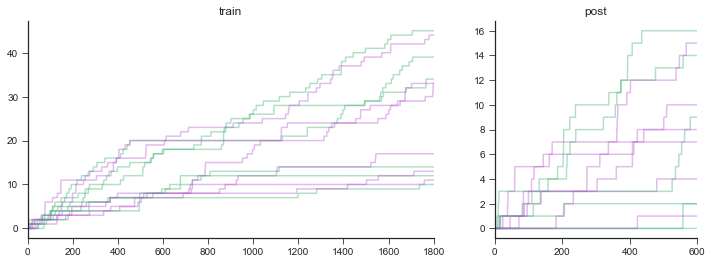

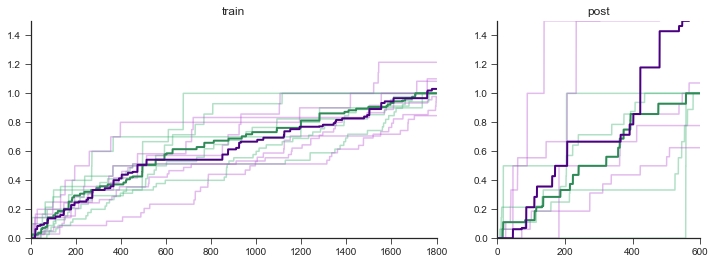

In [118]:
avLineCol = ['seagreen','indigo']

visitRad = visitRad
visitFig, cumsumVisitPlts = plt.subplots(1,len(trialName), figsize=(12,4), gridspec_kw = {'width_ratios':[2, 1]})
scaledVisitFig, scaledCumsumVisitPlts  = plt.subplots(1,len(trialName), figsize=(12,4),gridspec_kw = {'width_ratios':[2, 1]})

alphaVal = 0.4

for trial in range(len(trialName)):
    trialtype = trialName[trial]
    
    querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[0]+'")'
    timeTrial = FOAllFlies_df.query(querystring)['time'].values.squeeze()
    scaledVisits = np.nan*np.ones((numLM, numFlies, len(timeTrial)))
    
    for fly in range(numFlies):
        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        xPosTrial = FOAllFlies_df.query(querystring)['xPos'].values.squeeze()
        yPosTrial = FOAllFlies_df.query(querystring)['yPos'].values.squeeze()
        timeTrial = FOAllFlies_df.query(querystring)['time'].values.squeeze()
        
        # compute distance to closest landmark for each type
        dist2closest = np.nan*np.ones( (numLM, len(xPosTrial)) )
        
        LMentries = np.zeros((numLM,len(timeTrial)))
        
        for obj in range(numLM):
            dist2closest[obj,:] = np.minimum( np.hypot((xPosTrial-LMcoords[obj][0][0]),(yPosTrial-LMcoords[obj][0][1])),
                                           np.hypot((xPosTrial-LMcoords[obj][1][0]),(yPosTrial-LMcoords[obj][1][1])) )
            
            entries,exits,visitT,entryTime,exitTime = countvisits(dist2closest[obj,:],timeTrial, visitRad)
            LMentries[obj,:] = entries
        
        
        for obj in range(numLM):
            #plot results
            cumsumVisitPlts[trial].plot(timeTrial,np.cumsum(LMentries[obj,:]),color=LMCols[obj], alpha=alphaVal)
            scaledCumsumVisitPlts[trial].plot(timeTrial,np.cumsum(LMentries[obj,:])/sum(LMentries[0,:]),color=LMCols[obj], alpha=alphaVal)

            scaledVisits[obj, fly,:] = np.cumsum(LMentries[obj,:])/sum(LMentries[0,:])

    for obj in range(numLM):
        #plot averages
        scaledCumsumVisitPlts[trial].plot(timeTrial, np.nanmedian(scaledVisits[obj,:,:].squeeze(),axis=0),
                                          color = avLineCol[obj],linewidth=2)

    cumsumVisitPlts[trial].set_xlim(0,max(timeTrial))
    myAxisTheme(cumsumVisitPlts[trial])
    cumsumVisitPlts[trial].set_title(trialtype)
    
    scaledCumsumVisitPlts[trial].set_xlim(0,max(timeTrial))
    myAxisTheme(scaledCumsumVisitPlts[trial])
    scaledCumsumVisitPlts[trial].set_title(trialtype)
    scaledCumsumVisitPlts[trial].set_ylim(0,1.5)
        
try:
    mkdir(analysisDir + 'reinforcementEffect/')
except:
    print('Plot directory already exists')
visitFig.savefig(analysisDir + 'reinforcementEffect/'+ genotype +'_'+flyIDs[0][0]
                 +'_cumVisitComparison_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')
scaledVisitFig.savefig(analysisDir + 'reinforcementEffect/'+ genotype +'_'+flyIDs[0][0]
                       +'_coneScaledCumVisitComparison_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

## Visit count plots
### Shared settings for plots

In [119]:
# Settings for boxplots of all three trials:

objBoxColors = [['seagreen','mediumseagreen'],
                ['darkmagenta','mediumorchid']] #for spec. objects
BoxColors = ['slateblue','royalblue'] # for ratio between objects

trialColors = ['darkviolet','teal']
trialMarkers = ['*','o']

offsets = [1.3, 1.3]

boxalpha = 0.5
linealpha=0.5

allTrialFigSize = (12,4)
twoTrialFigSize = (16,4)

# Settings for boxplots of pre and post trial only
objBoxColors_pp = [['lightgreen','mediumseagreen'],
                   ['palevioletred','mediumorchid']]
BoxColors_pp = ['grey','royalblue'] 
offsets_pp = [1.32, 0.68]

### Visit count and visit frequency

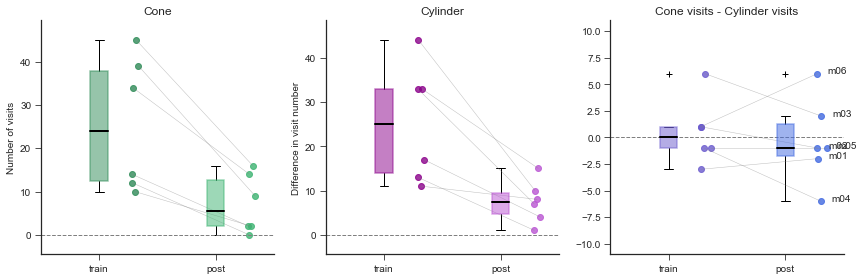

In [127]:
bpFig = plt.figure(figsize=allTrialFigSize)

VisitCountRatio = visitCount[0,:]-visitCount[1,:]

for objtype in range(len(LMnames)):
    bpPlt = bpFig.add_subplot(1,3,objtype+1)
    objBoxPlt = prettyBoxPlot_tele(bpPlt, objBoxColors[objtype], boxalpha, linealpha, visitCount[objtype],
                              flyIDs, offsets, trialName, plotLabels=False)

    objBoxPlt.set_ylabel('Number of visits')
    bpPlt.set_title(LMnames[objtype])

bpPlt = bpFig.add_subplot(1,3,3)
ratioBoxPlt = prettyBoxPlot_tele(bpPlt, BoxColors, boxalpha, linealpha, VisitCountRatio, flyIDs, offsets, 
                            trialName, plotLabels=True)

bpPlt.set_ylim((-5+np.min(VisitCountRatio),5+np.max(VisitCountRatio)))
objBoxPlt.set_ylabel('Difference in visit number')
bpPlt.set_title('Cone visits - Cylinder visits')

bpFig.tight_layout()

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
bpFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
                 +'_visitCount_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

p = 0.749633752711
Plot directory already exists


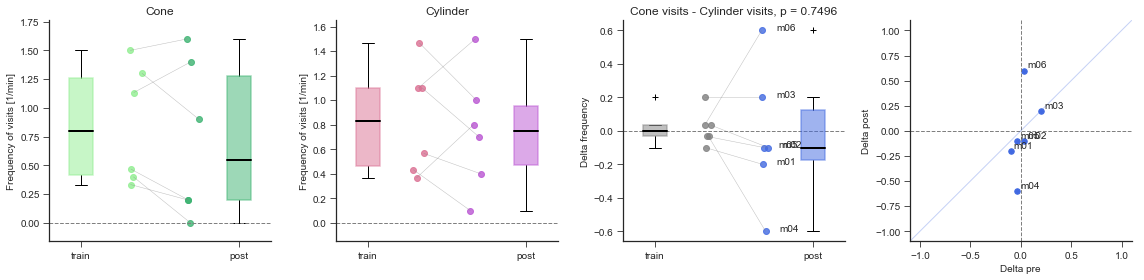

In [128]:
# compare just pre and post

VisitFreqRatio = visitFreq[0,:]-visitFreq[1,:]

bpFig = plt.figure(figsize=twoTrialFigSize)

for objtype in range(len(LMnames)):
    bpPlt = bpFig.add_subplot(1,4,objtype+1)
    
    objBoxPlt = prettyBoxPlot_tele(bpPlt, objBoxColors_pp[objtype], boxalpha, linealpha, visitFreq[objtype],
                             flyIDs, offsets_pp, trialName, plotLabels=False)
    
    bpPlt.set_xlim((0.8,2.2))
    bpPlt.set_ylabel('Frequency of visits [1/min]')
    bpPlt.set_title(LMnames[objtype])

bpPlt = bpFig.add_subplot(1,4,3)
ratioBoxPlt = prettyBoxPlot_tele(bpPlt, BoxColors_pp, boxalpha, linealpha, 
                            VisitFreqRatio, flyIDs, offsets_pp, trialName, plotLabels=True)

bpPlt.set_xlim((0.8,2.2))
bpPlt.set_ylim((-0.1*np.max(VisitFreqRatio)+np.min(VisitFreqRatio),
                0.1*np.max(VisitFreqRatio)+np.max(VisitFreqRatio)))
bpPlt.set_ylabel('Delta frequency')

from scipy import stats as sts
tval, pval = sts.ttest_rel(VisitFreqRatio[:,0], VisitFreqRatio[:,1],
              axis=0, nan_policy='propagate')
bpPlt.set_title('Cone visits - Cylinder visits, p = ' + str(round(pval,4)))
print('p = ' + str(pval))

# correlation between pre and post prefererence 
bpPlt = bpFig.add_subplot(1,4,4)

bpPlt = diffCorrPlot(bpPlt, VisitFreqRatio, flyIDs, BoxColors_pp[-1])

bpFig.tight_layout()

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
bpFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
              +'_visitFrequency_prePost_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
              +selectionTag+'.pdf', format='pdf')

np.savetxt(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
           +'_visitFrequency_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
           +selectionTag+'.csv', VisitFreqRatio,delimiter=',')

### Visit frequency over time (5 min blocks)

In [129]:
#Adjust to trial length
blockL = 5
trial5min = [int(30/blockL),int(10/blockL)]

BoxColors_5min = [[BoxColors[i]]*trial5min[i] for i in range(len(trialName))]
blockNames_5min = [[trialName[i]+' '+ str(t+1) for t in range(trial5min[i])]  for i in range(len(trialName))]
objBoxColors_5min_1 = [[objBoxColors[0][i]]*trial5min[i] for i in range(len(trialName))]
objBoxColors_5min_2 = [[objBoxColors[1][i]]*trial5min[i] for i in range(len(trialName))]
BoxColors_5min = [item for sublist in BoxColors_5min for item in sublist]
blockNames_5min = [item for sublist in blockNames_5min for item in sublist]
objBoxColors_5min = [[item for sublist in objBoxColors_5min_1 for item in sublist],
                    [item for sublist in objBoxColors_5min_2 for item in sublist]]

In [130]:
# Generate landmark visit count over 5 min blocks
visitCount_5min = np.zeros((len(LMnames), len(flyIDs), sum(trial5min)))
visitLength_5min = np.zeros((len(LMnames), len(flyIDs), sum(trial5min)))

for fly in range(len(flyIDs)):
    blockcount = 0
    
    for trial in range(len(trialName)):
        trialtype =trialName[trial]

        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        xPosTrial = FOAllFlies_df.query(querystring)['xPos'].values
        yPosTrial = FOAllFlies_df.query(querystring)['yPos'].values
        timeTrial = FOAllFlies_df.query(querystring)['time'].values
        evTrial = FOAllFlies_df.query(querystring)['rEvents'].values

        # compute distance to each landmark
        dist2cone1 = np.hypot((xPosTrial-coneCoords[0][0]),(yPosTrial-coneCoords[0][1]))
        dist2cone2 = np.hypot((xPosTrial-coneCoords[1][0]),(yPosTrial-coneCoords[1][1]))
        dist2cyli1 = np.hypot((xPosTrial-cyliCoords[0][0]),(yPosTrial-cyliCoords[0][1]))
        dist2cyli2 = np.hypot((xPosTrial-cyliCoords[1][0]),(yPosTrial-cyliCoords[1][1]))

        # compute distance to closest landmark
        dist2closestCone = np.minimum(dist2cone1,dist2cone2)
        dist2closestCyli = np.minimum(dist2cyli1,dist2cyli2)

        for block in range(trial5min[trial]):
            entriesCone,_,visitTCone,_,_ = countvisits(dist2closestCone[int(block*(fps*60*5+1)):int((block+1)*fps*60*5)], timeTrial[int(block*(fps*60*5+1)):int((block+1)*fps*60*5)], visitRad)
            entriesCyli,_,visitTCyli,_,_ = countvisits(dist2closestCyli[int(block*(fps*60*5+1)):int((block+1)*fps*60*5)], timeTrial[int(block*(fps*60*5+1)):int((block+1)*fps*60*5)], visitRad)

            visitCount_5min[0, fly, block+blockcount] = np.sum(entriesCone)
            visitCount_5min[1, fly, block+blockcount] = np.sum(entriesCyli)

            visitLength_5min[0, fly, block+blockcount] = np.sum(visitTCone)
            visitLength_5min[1, fly, block+blockcount] = np.sum(visitTCyli)
            
        blockcount = blockcount + trial5min[trial]

Plot directory already exists


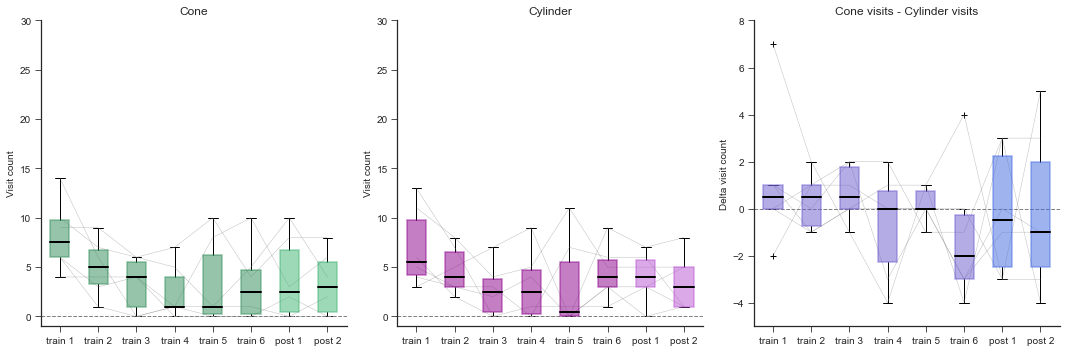

In [131]:
visitCountRatio_5min = visitCount_5min[0,:,:] - visitCount_5min[1,:,:]

bpFig, axs = plt.subplots(1,3,figsize=(15,5))

for objtype in range(len(LMnames)):    
    objBoxPlt = simpleBoxPlot(axs[objtype], objBoxColors_5min[objtype], boxalpha, linealpha, 
                              visitCount_5min[objtype,:,:], flyIDs, blockNames_5min)

    axs[objtype].set_ylabel('Visit count')
    axs[objtype].set_title(LMnames[objtype])
    axs[objtype].set_ylim(-1,30)

ratioBoxPlt = simpleBoxPlot(axs[2], BoxColors_5min, boxalpha, linealpha, visitCountRatio_5min, flyIDs,
                            blockNames_5min)

axs[2].set_ylim((np.min(visitCountRatio_5min)-1,np.max(visitCountRatio_5min)+1))
axs[2].set_title('Cone visits - Cylinder visits')
axs[2].set_ylabel('Delta visit count')

bpFig.tight_layout()

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
bpFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
                 +'_visitCount5min_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

Plot directory already exists


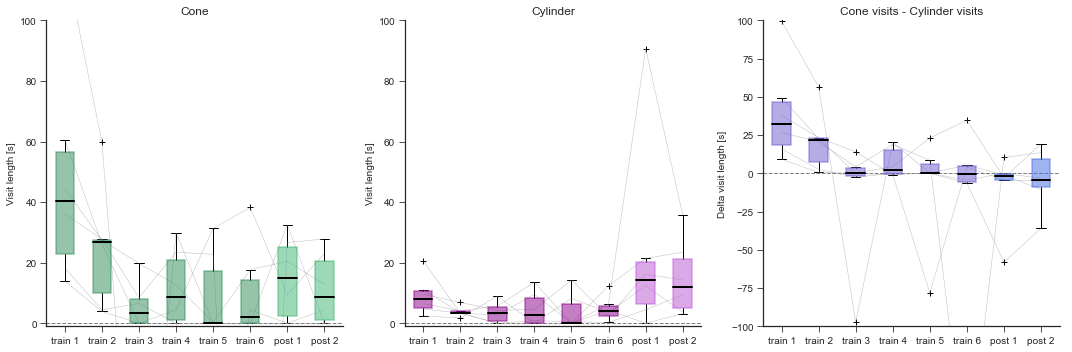

In [132]:
visitLength_5min_nan = visitLength_5min.copy()
visitLength_5min_nan[np.isnan(visitLength_5min_nan)] = 0

visitLengthRatio_5min = visitLength_5min_nan[0,:,:] - visitLength_5min_nan[1,:,:]

bpFig, axs = plt.subplots(1,3,figsize=(15,5))

for objtype in range(len(LMnames)):    
    objBoxPlt = simpleBoxPlot(axs[objtype], objBoxColors_5min[objtype], boxalpha, linealpha, 
                              visitLength_5min_nan[objtype,:,:], flyIDs, blockNames_5min)

    axs[objtype].set_ylabel('Visit length [s]')
    axs[objtype].set_title(LMnames[objtype])
    axs[objtype].set_ylim(-1,100)

ratioBoxPlt = simpleBoxPlot(axs[2], BoxColors_5min, boxalpha, linealpha, visitLengthRatio_5min, flyIDs,
                            blockNames_5min)

axs[2].set_ylim((-100, 100))
axs[2].set_title('Cone visits - Cylinder visits')
axs[2].set_ylabel('Delta visit length [s]')

bpFig.tight_layout()

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
bpFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
                 +'_visitLength5min_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

## Analysis of trajectory segments defined by teleportation events

In [23]:
try:
    mkdir(analysisDir + 'teleportRuns/')
except:
    print('Plot directory already exists')

Plot directory already exists


In [24]:
def drawTeleRad(ax, LMcoord, rad):
    for LM in range(len(LMcoord)):
        for i in range(2):
            circle = plt.Circle(LMcoord[LM][i], rad, color='grey', fill=False)
            ax.add_artist(circle)

In [25]:
trialtype = 'train'
fly = 2
querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
xtrial = FOAllFlies_df.query(querystring)['xPos'].values
ytrial = FOAllFlies_df.query(querystring)['yPos'].values
evtrial = FOAllFlies_df.query(querystring)['rEvents'].values
time = FOAllFlies_df.query(querystring)['time'].values
head = FOAllFlies_df.query(querystring)['headingAngle'].values

dist = np.hypot(xtrial,ytrial)

dist2closest = np.nan*np.ones( (numLM, len(xtrial)) )

for obj in range(numLM):
    dist2closest[obj,:] = np.minimum( np.hypot((xtrial-LMcoords[obj][0][0]),(ytrial-LMcoords[obj][0][1])),
                                    np.hypot((xtrial-LMcoords[obj][1][0]),(ytrial-LMcoords[obj][1][1])) )
    
jumpDist = 5*np.std(np.diff(dist))
jumps = np.hstack((0,np.where(np.diff(dist)<-jumpDist)[0]+1))

# remove jumps, if it directly follows an other one
jumps = np.hstack((0,jumps[np.where(np.diff(jumps)>1)[0]+1]))
len(jumps)

68

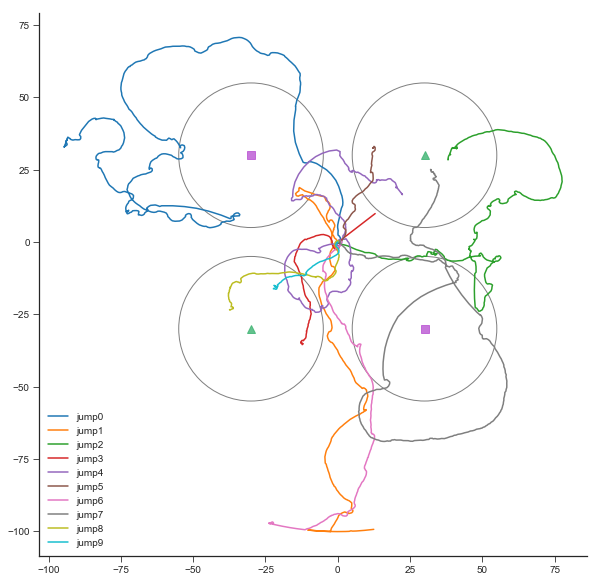

In [26]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

for i in range(0,10):
    ax.plot(xtrial[jumps[i]:jumps[i+1]],ytrial[jumps[i]:jumps[i+1]])
    
ax.legend(['jump'+str(i) for i in range(10)])
landmarksInSquareTile(ax,LMcoords,LMCols)
drawTeleRad(ax, LMcoords, 25)


(-70, 70)

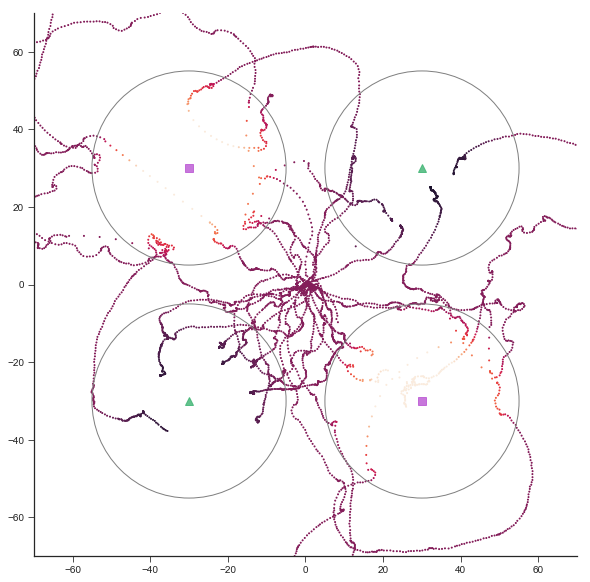

In [27]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
for i in range(0,20):
    ax.scatter(xtrial[jumps[i]:jumps[i+1]],ytrial[jumps[i]:jumps[i+1]],s=1,
               c=evtrial[jumps[i]:jumps[i+1]], vmin=0, vmax=30)
    
landmarksInSquareTile(ax,LMcoords,LMCols)
drawTeleRad(ax, LMcoords, 25)
ax.set_xlim(-70,70)
ax.set_ylim(-70,70)

### Condition on initial heading

In [49]:
maxTargetDist = 25
minTargetDist = 35

jumpRanges = [(0,20), (20,40), (40,60)]

cone -> cone: 0.727272727273 
 cone -> cyli: 0.0 
 cyli -> cone: 0.666666666667 
 cyli -> cyli: 0.0

cone -> cone: 0.428571428571 
 cone -> cyli: 0.0 
 cyli -> cone: 0.615384615385 
 cyli -> cyli: 0.0769230769231

cone -> cone: 0.666666666667 
 cone -> cyli: 0.0 
 cyli -> cone: 0.2 
 cyli -> cyli: 0.0



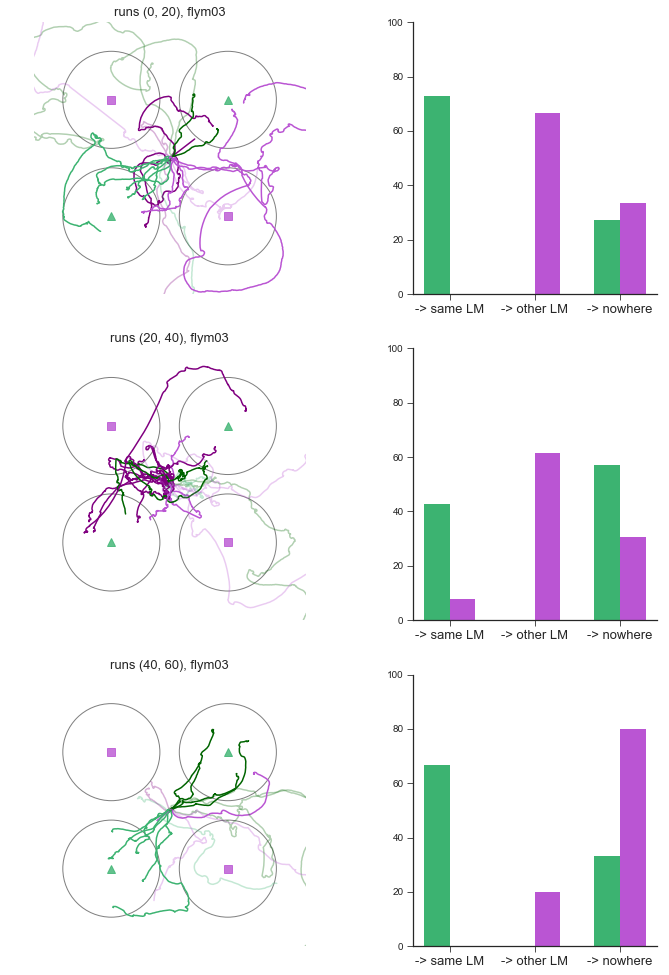

In [57]:
trialtype = 'train'
fly = 2

querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
xtrial = FOAllFlies_df.query(querystring)['xPos'].values
ytrial = FOAllFlies_df.query(querystring)['yPos'].values
head = FOAllFlies_df.query(querystring)['headingAngle'].values

dist = np.hypot(xtrial,ytrial)

dist2closest = np.nan*np.ones( (numLM, len(xtrial)) )

for obj in range(numLM):
    dist2closest[obj,:] = np.minimum( np.hypot((xtrial-LMcoords[obj][0][0]),(ytrial-LMcoords[obj][0][1])),
                                    np.hypot((xtrial-LMcoords[obj][1][0]),(ytrial-LMcoords[obj][1][1])) )
    
jumpDist = 5*np.std(np.diff(dist))
jumps = np.hstack((0,np.where(np.diff(dist)<-jumpDist)[0]+1))

# remove jumps, if it directly follows an other one
jumps = np.hstack((0,jumps[np.where(np.diff(jumps)>1)[0]+1]))
len(jumps)

fig, ax = plt.subplots(len(jumpRanges),2,figsize=(12,17), gridspec_kw={'width_ratios':[1.5,1]})

for k, jR in enumerate(jumpRanges):

    if(jR[1]>=len(jumps)):
        ax[k, 0].axis('off')
        ax[k, 1].axis('off')
        continue
        
    condTarget = np.zeros((2,3))

    for i in range(jR[0],jR[1]):
        
        firstInSight = np.where(np.min(dist2closest[:,jumps[0]:jumps[0+1]],axis=0)<minTargetDist)[0][0]
        fovSt = head[jumps[i]+firstInSight]*180/np.pi
        
        if min(dist2closest[:, jumps[i+1]-1]) > maxTargetDist:
            targetLM = 2
            alphav=0.3
        else:
            alphav = 1
            targetLM = np.argmin(dist2closest[:, jumps[i+1]-1])

        if fovSt<=0 and fovSt >-90: # cyli
            condTarget[1,targetLM] +=1
            ax[k, 0].plot(xtrial[jumps[i]:jumps[i+1]],ytrial[jumps[i]:jumps[i+1]], color=LMCols[1], alpha=alphav)

        elif fovSt<=-90: #cone
            condTarget[0,targetLM] +=1
            ax[k, 0].plot(xtrial[jumps[i]:jumps[i+1]],ytrial[jumps[i]:jumps[i+1]], color=LMCols[0], alpha=alphav)

        elif fovSt>0 and fovSt <90: # cone
            condTarget[0,targetLM] +=1
            ax[k, 0].plot(xtrial[jumps[i]:jumps[i+1]],ytrial[jumps[i]:jumps[i+1]], color='darkgreen', alpha=alphav)

        else: #fovSt>0 and fovSt >90 # cyli
            condTarget[1,targetLM] +=1
            ax[k, 0].plot(xtrial[jumps[i]:jumps[i+1]],ytrial[jumps[i]:jumps[i+1]], color='purple', alpha=alphav)


    landmarksInSquareTile(ax[k, 0],LMcoords,LMCols)
    drawTeleRad(ax[k, 0], LMcoords, 25)
    ax[k, 0].axis('off')
    ax[k, 0].set_xlim(-70,70)
    ax[k, 0].set_ylim(-70,70)

    barwidth = 0.3
    fromConeFov = 100.*condTarget[0,:]/np.sum(condTarget[0,:])
    fromCyliFov = 100.*condTarget[1,:]/np.sum(condTarget[1,:])
    fromCyliFov[0] = fromCyliFov[1]
    fromCyliFov[1] = 100.*condTarget[1,0]/np.sum(condTarget[1,:])

    ind = np.arange(len(fromConeFov)) 
    ax[k, 1].bar(ind - barwidth/2, fromConeFov, width= barwidth, color=LMCols[0])
    ax[k, 1].bar(ind + barwidth/2, fromCyliFov, width= barwidth, color=LMCols[1])

    ax[k, 1].set_xticks(ind)
    ax[k, 1].set_xticklabels(('-> same LM', '-> other LM', '-> nowhere'), fontsize=13)
    ax[k, 1].set_ylim(0,100)
    myAxisTheme(ax[k, 1])
    
    ax[k, 0].set_title('runs '+str(jR)+', fly' + flyIDs[fly], fontsize=13)

    print('cone -> cone: {0} \n cone -> cyli: {1} \n cyli -> cone: {2} \n cyli -> cyli: {3}\n'.format(
          condTarget[0,0]/np.sum(condTarget[0,:]),condTarget[0,1]/np.sum(condTarget[0,:]),
        condTarget[1,0]/np.sum(condTarget[1,:]),condTarget[1,1]/np.sum(condTarget[1,:])))

#fig.suptitle('fly' + flyIDs[fly])
fig.savefig(analysisDir + 'teleportRuns/'+ genotype +flyIDs[0][0]
                +'_runEffects_'+trialtype+'_minFOVDist'+str(minTargetDist)+'mm_maxTargetDist'+str(maxTargetDist)+'mm_fly'+ flyIDs[fly] +'.pdf', format='pdf')

In [31]:
allCondTarget = np.nan*np.ones((len(jumpRanges),numFlies,2,3))

for fly in range(numFlies):
    querystring = '(trialtype=="train") & (flyID == "'+flyIDs[fly]+'")'
    xtrial = FOAllFlies_df.query(querystring)['xPos'].values
    ytrial = FOAllFlies_df.query(querystring)['yPos'].values
    head = FOAllFlies_df.query(querystring)['headingAngle'].values

    dist = np.hypot(xtrial,ytrial)

    dist2closest = np.nan*np.ones( (numLM, len(xtrial)) )

    for obj in range(numLM):
        dist2closest[obj,:] = np.minimum( np.hypot((xtrial-LMcoords[obj][0][0]),(ytrial-LMcoords[obj][0][1])),
                                        np.hypot((xtrial-LMcoords[obj][1][0]),(ytrial-LMcoords[obj][1][1])) )

    jumpDist = 5*np.std(np.diff(dist))
    jumps = np.hstack((0,np.where(np.diff(dist)<-jumpDist)[0]+1))

    # remove jumps, if it directly follows an other one
    jumps = np.hstack((0,jumps[np.where(np.diff(jumps)>1)[0]+1]))

    for k, jR in enumerate(jumpRanges):

        if(jR[1]>=len(jumps)):
            continue
        condTarget = np.zeros((2,3))

        for i in range(jR[0],jR[1]):
            firstInSight = np.where(np.min(dist2closest[:,jumps[0]:jumps[0+1]],axis=0)<minTargetDist)[0][0]
            fovSt = head[jumps[i]+firstInSight]*180/np.pi

            targetLM = np.argmin(dist2closest[:, jumps[i+1]-1])
            if min(dist2closest[:, jumps[i+1]-1]) > maxTargetDist:
                targetLM = 2
                alphav=0.3
            else:
                alphav = 1

            if fovSt<=0 and fovSt >-90: # cyli
                condTarget[1,targetLM] +=1

            elif fovSt<=-90: #cone
                condTarget[0,targetLM] +=1

            elif fovSt>0 and fovSt <90: # cone
                condTarget[0,targetLM] +=1

            else: #fovSt>0 and fovSt >90 # cyli
                condTarget[1,targetLM] +=1

        fromConeFov = 100.*condTarget[0,:]/np.sum(condTarget[0,:])
        fromCyliFov = 100.*condTarget[1,:]/np.sum(condTarget[1,:])
        fromCyliFov[0] = fromCyliFov[1]
        fromCyliFov[1] = 100.*condTarget[1,0]/np.sum(condTarget[1,:])

        allCondTarget[k, fly,0,:] = fromConeFov
        allCondTarget[k, fly,1,:] = fromCyliFov

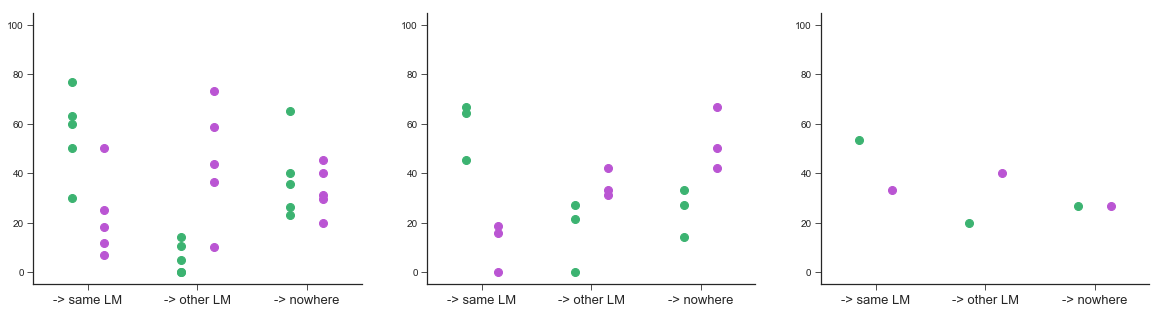

In [32]:
fig, axs = plt.subplots(1,len(jumpRanges),figsize=(20,5))

for k, jR in enumerate(jumpRanges):
    for fly in range(numFlies):
        fromConeFov = 100*allCondTarget[k,fly,0,:]/np.sum(allCondTarget[k,fly,0,:])
        fromCyliFov = 100*allCondTarget[k,fly,1,:]/np.sum(allCondTarget[k,fly,1,:])

        ind = np.arange(len(fromConeFov)) +1
        axs[k].plot(ind - 0.15, fromConeFov, 'o', color=LMCols[0], markersize=8)
        axs[k].plot(ind + 0.15, fromCyliFov, 'o', color=LMCols[1], markersize=8)

    axs[k].set_xticks(ind)
    axs[k].set_xticklabels(('-> same LM', '-> other LM', '-> nowhere'), fontsize=13)
    myAxisTheme(axs[k])
    axs[k].set_xlim(0.5,3.5)
    axs[k].set_ylim(-5,105)

(0, 140)

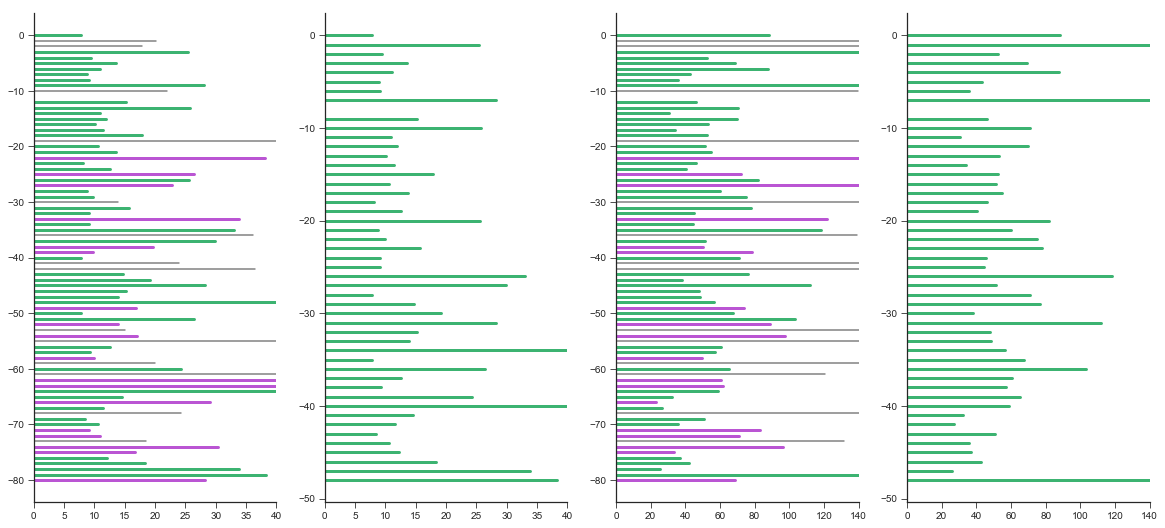

In [34]:
trialtype = 'train'
maxTargetDist = 45

fly = 1


fig, axs = plt.subplots(1,4,figsize=(20,9))

trialOffset = 0
coneTarget = 0

querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
xtrial = FOAllFlies_df.query(querystring)['xPos'].values
ytrial = FOAllFlies_df.query(querystring)['yPos'].values
time = FOAllFlies_df.query(querystring)['time'].values
head = FOAllFlies_df.query(querystring)['headingAngle'].values

dist = np.hypot(xtrial,ytrial)

dist2closest = np.nan*np.ones( (numLM, len(xtrial)) )

for obj in range(numLM):
    dist2closest[obj,:] = np.minimum( np.hypot((xtrial-LMcoords[obj][0][0]),(ytrial-LMcoords[obj][0][1])),
                                    np.hypot((xtrial-LMcoords[obj][1][0]),(ytrial-LMcoords[obj][1][1])) )

jumpDist = 5*np.std(np.diff(dist))
jumps = np.where(np.diff(dist)<-jumpDist)[0]+1

st = 0

for i, jump in enumerate(jumps):
    targetLM = np.argmin(dist2closest[:, jump-1])
    
    distTravelled = np.sum(np.hypot(np.diff(xtrial[st:jump]), np.diff(ytrial[st:jump])))
    
    if min(dist2closest[:, jump-1]) > maxTargetDist:
        axs[0].plot(time[st:jump-1]-time[st],-trialOffset*np.ones(len(time[st:jump-1])), color='grey')
        axs[2].plot([0,distTravelled],-trialOffset*np.ones(2), color='grey')

    else:
        axs[0].plot(time[st:jump-1]-time[st],-trialOffset*np.ones(len(time[st:jump-1])), color=LMCols[targetLM], linewidth=3)
        axs[2].plot([0,distTravelled],-trialOffset*np.ones(2), color=LMCols[targetLM], linewidth=3)

        if targetLM ==0:
            axs[1].plot(time[st:jump-1]-time[st],-coneTarget*np.ones(len(time[st:jump-1])),
                        color=LMCols[targetLM], linewidth=3)
            axs[3].plot([0,distTravelled],-coneTarget*np.ones(2),
                        color=LMCols[targetLM], linewidth=3)
            coneTarget +=1
    st = jump
    trialOffset += 1

for ax in axs:
    myAxisTheme(ax)
axs[0].set_xlim(0,40)
axs[1].set_xlim(0,40)
axs[2].set_xlim(0,140)
axs[3].set_xlim(0,140)

#### Compute time in cool area for each jump

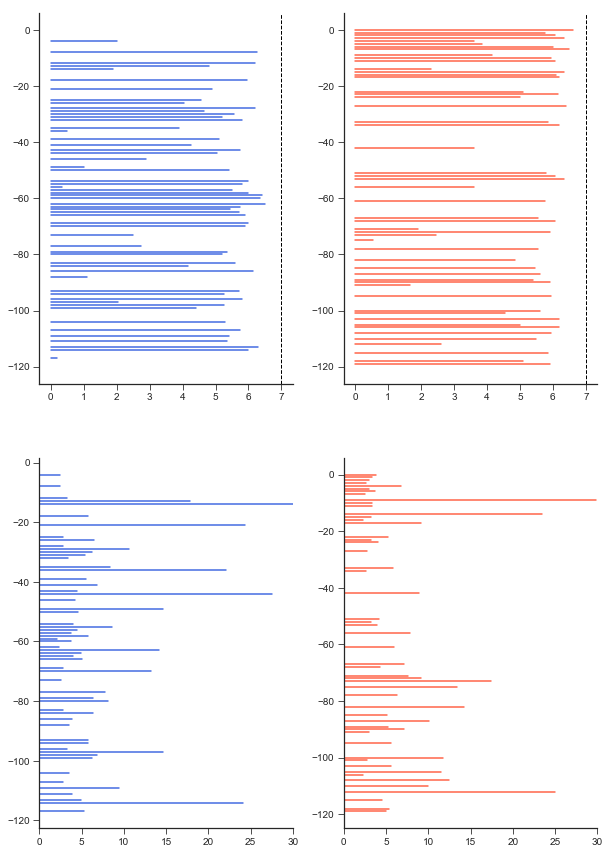

In [572]:
trialtype = 'train'
coolSt = 25

fly = 1


fig, axs = plt.subplots(2,2,figsize=(10,15))

trialOffset = 0
coneTarget = 0

querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
xtrial = FOAllFlies_df.query(querystring)['xPos'].values
ytrial = FOAllFlies_df.query(querystring)['yPos'].values
time = FOAllFlies_df.query(querystring)['time'].values
head = FOAllFlies_df.query(querystring)['headingAngle'].values

dist = np.hypot(xtrial,ytrial)

dist2closest = np.nan*np.ones( (numLM, len(xtrial)) )

for obj in range(numLM):
    dist2closest[obj,:] = np.minimum( np.hypot((xtrial-LMcoords[obj][0][0]),(ytrial-LMcoords[obj][0][1])),
                                    np.hypot((xtrial-LMcoords[obj][1][0]),(ytrial-LMcoords[obj][1][1])) )

jumpDist = 5*np.std(np.diff(dist))
jumps = np.where(np.diff(dist)<-jumpDist)[0]+1

st = 0

toCool = []
itoCool = []
toHot = []
itoHot = []

for i, jump in enumerate(jumps):
    inCoolZone  = dist2closest[0,st:jump-1]<=coolSt

    inHotZone  = dist2closest[1,st:jump-1]<=coolSt

    axs[0,0].plot([0,sum(inCoolZone)/(1.0*fps)],-i*np.ones(2), color='royalblue')
    
    axs[0,1].plot([0,sum(inHotZone)/(1.0*fps)],-i*np.ones(2), color='tomato')

    if sum(inCoolZone)>0:
        axs[1,0].plot([0,np.where(inCoolZone)[0][0]/(1.0*fps)],-i*np.ones(2), color='royalblue')
        toCool.append(np.where(inCoolZone)[0][0]/(1.0*fps))
        itoCool.append(i)
    if sum(inHotZone)>0:
        axs[1,1].plot([0,np.where(inHotZone)[0][0]/(1.0*fps)],-i*np.ones(2), color='tomato')
        toHot.append(np.where(inHotZone)[0][0]/(1.0*fps))
        itoHot.append(i)
    
    
    st = jump
    
        
for ax in axs[0]:
    myAxisTheme(ax)
    ax.axvline(7,color='k', linestyle='dashed', linewidth=1)
    
for ax in axs[1]:
    myAxisTheme(ax)
    ax.set_xlim(0,30)
    

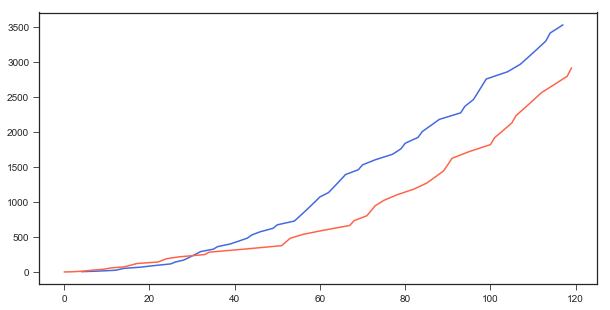

In [573]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(itoCool, np.cumsum(itoCool), color='royalblue')
ax.plot(itoHot, np.cumsum(itoHot), color='tomato')

104

(-207, 0)

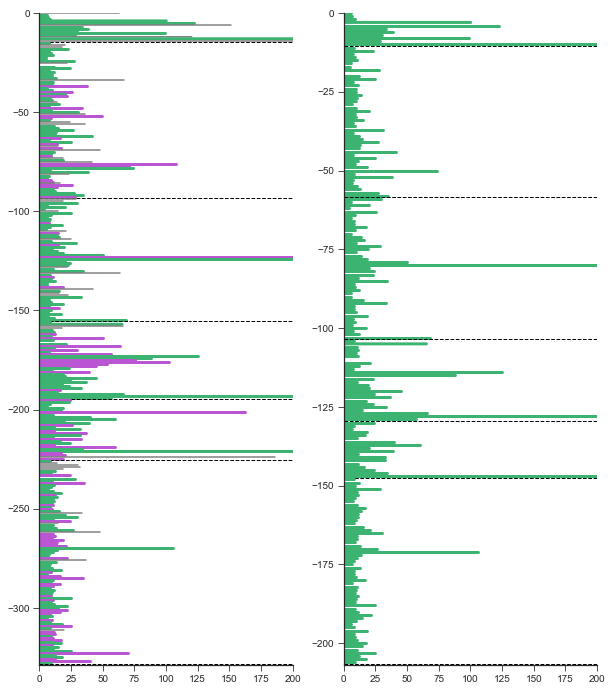

In [102]:
trialtype = 'train'
maxTargetDist = 45

fig, axs = plt.subplots(1,2,figsize=(10,12))

trialOffset = 0
coneTarget = 0

for fly in range(numFlies):
    querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'") & (moving>0)'
    xtrial = FOAllFlies_df.query(querystring)['xPos'].values
    ytrial = FOAllFlies_df.query(querystring)['yPos'].values
    time = FOAllFlies_df.query(querystring)['time'].values

    dist = np.hypot(xtrial,ytrial)

    dist2closest = np.nan*np.ones( (numLM, len(xtrial)) )

    for obj in range(numLM):
        dist2closest[obj,:] = np.minimum( np.hypot((xtrial-LMcoords[obj][0][0]),(ytrial-LMcoords[obj][0][1])),
                                        np.hypot((xtrial-LMcoords[obj][1][0]),(ytrial-LMcoords[obj][1][1])) )

    jumpDist = 5*np.std(np.diff(dist))
    jumps = np.where(np.diff(dist)<-jumpDist)[0]+1

    st = 0

    for i, jump in enumerate(jumps):
        targetLM = np.argmin(dist2closest[:, jump-1])
        if min(dist2closest[:, jump-1]) > maxTargetDist:
            axs[0].plot(time[st:jump-1]-time[st],-trialOffset*np.ones(len(time[st:jump-1])), color='grey')
        else:
            axs[0].plot(time[st:jump-1]-time[st],-trialOffset*np.ones(len(time[st:jump-1])), color=LMCols[targetLM], linewidth=3)

            if targetLM ==0:
                axs[1].plot(time[st:jump-1]-time[st],-coneTarget*np.ones(len(time[st:jump-1])),
                            color=LMCols[targetLM], linewidth=3)
                coneTarget +=1
        st = jump
        trialOffset += 1
    
    axs[0].axhline(-trialOffset+0.5,color='k', linestyle='dashed', linewidth=1)
    axs[1].axhline(-coneTarget+0.5, color='k', linestyle='dashed', linewidth=1)
    
        
for ax in axs:
    myAxisTheme(ax)
    ax.set_xlim(0,10*fps)
axs[0].set_ylim(-trialOffset,0)
axs[1].set_ylim(-coneTarget,0)

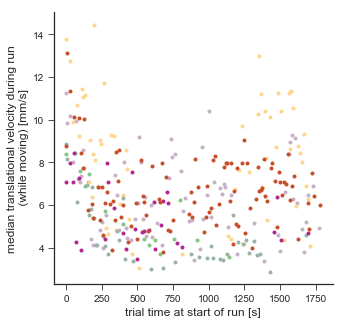

In [109]:
trialtype = 'train'
maxTargetDist = 45

fig, axs = plt.subplots(1,1,figsize=(5,5))

for fly in range(numFlies):
    querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'") & (moving>0)'
    xtrial = FOAllFlies_df.query(querystring)['xPos'].values
    ytrial = FOAllFlies_df.query(querystring)['yPos'].values
    vT = FOAllFlies_df.query(querystring)['transVelo'].values
    time = FOAllFlies_df.query(querystring)['time'].values

    dist = np.hypot(xtrial,ytrial)

    jumpDist = 5*np.std(np.diff(dist))
    jumps = np.where(np.diff(dist)<-jumpDist)[0]
    
    st = 0
    for i, jump in enumerate(jumps):
        axs.plot(time[st],np.nanmedian(vT[st:jump-1]), '.', color=flyCMap.to_rgba(fly))
        
        st = jump
        
myAxisTheme(axs)
axs.set_xlabel('trial time at start of run [s]', fontsize=12)
axs.set_ylabel('median translational velocity during run\n (while moving) [mm/s]', fontsize=12);